In [2]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd

In [3]:
from utils import process_from_census_data, TRS

### Import getting model

In [4]:
model = keras.models.load_model("cnn_20.keras")

## Combine to get total EV for each SA1 in the final

### Process data

In [14]:
file_loc = "output/EV_pred"
geo_lev = "POA"

In [11]:
poa_data, poa_tot = process_from_census_data(geo_lev="POA", normalise=False, boxcox=False, keep_same=True, return_tot=True)
electric_vals = poa_data["Fuel type__Electric"]

In [12]:
electric_vals

3000    170.0
3002     32.0
3003     19.0
3004     82.0
3006     56.0
        ...  
3990      0.0
3991      0.0
3992      0.0
3995     14.0
3996     10.0
Name: Fuel type__Electric, Length: 691, dtype: float64

In [15]:
df_all = pd.read_csv(f"{file_loc}/{geo_lev}_EV_pred_all.csv")
df_all[geo_lev] = df_all[geo_lev].astype(str)

In [32]:
dict_num_ev =  {f"POA{poa}": int(val) for poa, val in zip(electric_vals.index, electric_vals)}

ls_zone_not_exist =  []
for z in df_all[geo_lev].unique():
    check = z[3:]
    if check not in electric_vals.index:
        print(check)
        dict_num_ev[f"POA{check}"] = 0 #special case

3644
3691
3707


In [17]:
ls_cols_ev_pred = [x for x in df_all.columns if "EV_pred" in x]

In [18]:
combine_fin_df = df_all[ls_cols_ev_pred+[geo_lev]]

## Assigning EV

In [19]:
combine_fin_df

,EV_pred_forest,EV_pred_baye,EV_pred_lr,EV_pred_GraBoost,EV_pred_Pearsons,POA
0,0.006153,0.011787,-0.016936,0.002052,0.528474,POA3000
1,0.003944,0.010410,0.009832,0.001441,0.339234,POA3000
2,0.003435,0.009044,0.026785,0.001441,0.152534,POA3000
3,0.003180,0.007614,0.012467,0.001441,0.151239,POA3000
4,0.002398,0.009283,0.007622,0.001441,0.062332,POA3000
...,...,...,...,...,...,...
2390809,0.002443,0.001969,0.033027,0.001441,0.035259,POA3996
2390810,0.002146,-0.002589,-0.001190,0.001441,-0.113637,POA3996
2390811,0.005030,0.008055,0.007859,0.001441,0.305439,POA3996
2390812,0.004118,0.000006,-0.023657,0.001441,0.089287,POA3996


In [33]:
# Make sense to have higher, some sa1 does not have households
print(len(dict_num_ev), len(df_all[geo_lev].unique()))

694 692


In [34]:
dict_thres = {}
ls_df = [] # Note these one will have diff index matching with original to combine later

for zone in df_all[geo_lev].unique():
    print(f"DOING {zone}")
    dict_thres[zone] = {}
    sub_df = combine_fin_df[combine_fin_df[geo_lev]==zone]
    num_ev = dict_num_ev[zone]
    ls_series = []
    for ev_pred in ls_cols_ev_pred:
        sort_df = sub_df.sort_values(ev_pred, ascending=False)
        n = len(sort_df)
        arr_val = ["NO" for _ in range(n)]
        arr_val[:num_ev] = ["YES" for _ in range(num_ev)]
        seri_ev_count = pd.Series(arr_val, index=sort_df.index, name=f"check_{ev_pred}")
        ls_series.append(seri_ev_count)

        # Find thres
        thres = sort_df[ev_pred].iat[num_ev-1]
        dict_thres[zone][ev_pred] = thres
    df_zone = pd.concat(ls_series, axis=1) # note the index
    ls_df.append(df_zone)

DOING POA3000
DOING POA3002
DOING POA3003
DOING POA3004
DOING POA3006
DOING POA3008
DOING POA3011
DOING POA3012
DOING POA3013
DOING POA3015
DOING POA3016
DOING POA3018
DOING POA3019
DOING POA3020
DOING POA3021
DOING POA3022
DOING POA3023
DOING POA3024
DOING POA3025
DOING POA3026
DOING POA3027
DOING POA3028
DOING POA3029
DOING POA3030
DOING POA3031
DOING POA3032
DOING POA3033
DOING POA3034
DOING POA3036
DOING POA3037
DOING POA3038
DOING POA3039
DOING POA3040
DOING POA3041
DOING POA3042
DOING POA3043
DOING POA3044
DOING POA3046
DOING POA3047
DOING POA3048
DOING POA3049
DOING POA3051
DOING POA3052
DOING POA3053
DOING POA3054
DOING POA3055
DOING POA3056
DOING POA3057
DOING POA3058
DOING POA3059
DOING POA3060
DOING POA3061
DOING POA3063
DOING POA3064
DOING POA3065
DOING POA3066
DOING POA3067
DOING POA3068
DOING POA3070
DOING POA3071
DOING POA3072
DOING POA3073
DOING POA3074
DOING POA3075
DOING POA3076
DOING POA3078
DOING POA3079
DOING POA3081
DOING POA3082
DOING POA3083
DOING POA3084
DOING 

In [35]:
ev_as_df = pd.concat(ls_df)
ev_as_df = ev_as_df.sort_index()
ev_as_df

,check_EV_pred_forest,check_EV_pred_baye,check_EV_pred_lr,check_EV_pred_GraBoost,check_EV_pred_Pearsons
0,NO,NO,NO,NO,YES
1,NO,NO,NO,NO,NO
2,NO,NO,NO,NO,NO
3,NO,NO,NO,NO,NO
4,NO,NO,NO,NO,NO
...,...,...,...,...,...
2390809,NO,NO,NO,NO,NO
2390810,NO,NO,NO,NO,NO
2390811,NO,NO,NO,NO,NO
2390812,NO,NO,NO,NO,NO


In [36]:
final_df_all = pd.concat([combine_fin_df, ev_as_df], axis=1)
final_df_all

,EV_pred_forest,EV_pred_baye,EV_pred_lr,EV_pred_GraBoost,EV_pred_Pearsons,POA,check_EV_pred_forest,check_EV_pred_baye,check_EV_pred_lr,check_EV_pred_GraBoost,check_EV_pred_Pearsons
0,0.006153,0.011787,-0.016936,0.002052,0.528474,POA3000,NO,NO,NO,NO,YES
1,0.003944,0.010410,0.009832,0.001441,0.339234,POA3000,NO,NO,NO,NO,NO
2,0.003435,0.009044,0.026785,0.001441,0.152534,POA3000,NO,NO,NO,NO,NO
3,0.003180,0.007614,0.012467,0.001441,0.151239,POA3000,NO,NO,NO,NO,NO
4,0.002398,0.009283,0.007622,0.001441,0.062332,POA3000,NO,NO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...
2390809,0.002443,0.001969,0.033027,0.001441,0.035259,POA3996,NO,NO,NO,NO,NO
2390810,0.002146,-0.002589,-0.001190,0.001441,-0.113637,POA3996,NO,NO,NO,NO,NO
2390811,0.005030,0.008055,0.007859,0.001441,0.305439,POA3996,NO,NO,NO,NO,NO
2390812,0.004118,0.000006,-0.023657,0.001441,0.089287,POA3996,NO,NO,NO,NO,NO


In [37]:
check_cols = [x for x in final_df_all.columns if "check_" in x]

for c in check_cols:
    print(final_df_all[c].value_counts())

check_EV_pred_forest
NO     2382995
YES       7819
Name: count, dtype: int64
check_EV_pred_baye
NO     2382995
YES       7819
Name: count, dtype: int64
check_EV_pred_lr
NO     2382995
YES       7819
Name: count, dtype: int64
check_EV_pred_GraBoost
NO     2382995
YES       7819
Name: count, dtype: int64
check_EV_pred_Pearsons
NO     2382995
YES       7819
Name: count, dtype: int64


In [38]:
final_df_all.to_csv("output/EV_pred/POA_FIN_EV_assignment.csv", index=False)

# Mapping to get the final plot

In [53]:
import matplotlib.pyplot as plt
import geopandas as gpd

### Prep data

In [46]:
df_pop = df_all.drop(columns=ls_cols_ev_pred+["hhid", "POA"])
df_pop = pd.concat([df_pop, ev_as_df], axis=1)
df_pop

,hhsize,dwelltype,hhinc,totalvehs,owndwell,check_EV_pred_forest,check_EV_pred_baye,check_EV_pred_lr,check_EV_pred_GraBoost,check_EV_pred_Pearsons
0,6.0,Terrace/Townhouse,5125.0,1.0,Being Purchased,NO,NO,NO,NO,YES
1,6.0,Separate House,3500.0,2.0,Being Rented,NO,NO,NO,NO,NO
2,6.0,Separate House,1150.0,2.0,Being Rented,NO,NO,NO,NO,NO
3,6.0,Separate House,1375.0,2.0,Being Rented,NO,NO,NO,NO,NO
4,6.0,Terrace/Townhouse,900.0,2.0,Fully Owned,NO,NO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...,...
2390809,1.0,Flat or Apartment,500.0,0.0,Being Rented,NO,NO,NO,NO,NO
2390810,1.0,Other,900.0,1.0,Being Rented,NO,NO,NO,NO,NO
2390811,1.0,Flat or Apartment,3875.0,0.0,Being Purchased,NO,NO,NO,NO,NO
2390812,1.0,Separate House,2500.0,1.0,Being Purchased,NO,NO,NO,NO,NO


In [75]:
dict_counts_methods_atts = {}
ls_check_methods = [f"check_{x}" for x in ls_cols_ev_pred]
# Check each methods
for method in ls_check_methods:
    dict_counts_methods_atts[method] = {}
    df_ev_own = df_pop[df_pop[method]=="YES"]
    df_ev_own.drop(columns=ls_check_methods)
    for att in df_ev_own.columns:
        val_counts = df_ev_own[att].value_counts()
        dict_counts_methods_atts[method][att] = val_counts.sort_index()

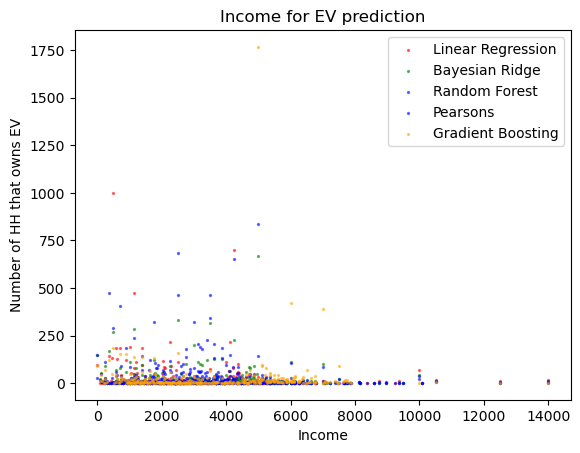

In [119]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

forest = dict_counts_methods_atts["check_EV_pred_forest"]['hhinc']
baye = dict_counts_methods_atts["check_EV_pred_baye"]['hhinc']
lr = dict_counts_methods_atts["check_EV_pred_lr"]['hhinc']
graboost = dict_counts_methods_atts["check_EV_pred_GraBoost"]['hhinc']
pears = dict_counts_methods_atts["check_EV_pred_Pearsons"]['hhinc']

ax1.scatter(lr.index, lr.values, s=2, c='r', label='Linear Regression', alpha=0.5)
ax1.scatter(baye.index, baye.values, s=2, c='g', label='Bayesian Ridge', alpha=0.5)
ax1.scatter(forest.index, forest.values, s=2, c='b', label='Random Forest', alpha=0.5)
ax1.scatter(pears.index, pears.values, s=2, c='b', label='Pearsons', alpha=0.5)
ax1.scatter(graboost.index, graboost.values, s=2, c='orange', label='Gradient Boosting', alpha=0.5)

plt.xlabel("Income")
plt.ylabel("Number of HH that owns EV")
plt.title("Income for EV prediction")
plt.legend(loc='upper right')

In [114]:
def to_plot_mul_bars(dict_check, ls_methods, att):
    X_lab = df_all[att].unique()
    X_lab.sort()
    hold_val = {}

    for method in ls_methods:
        name_check = f"check_EV_pred_{method}"
        series_counts = dict_check[name_check][att]
        arr_val = []
        for val in X_lab:
            if val not in series_counts.index: 
                arr_val.append(0)
            else:
                arr_val.append(series_counts[val])
        hold_val[method] = arr_val

    x = np.arange(len(X_lab))  # the label locations
    width = 0.1  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(20, 10))

    for attribute, counts in hold_val.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, counts, width, label=attribute)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of HHs that have EV')
    ax.set_title(f'Analyse {geo_lev} - {att}')
    ax.set_xticks(x + width, X_lab)
    ax.legend(loc='best', ncols=3)

    plt.show()


ls_methods = ["forest", "baye", "lr", "GraBoost", "Pearsons"]
    

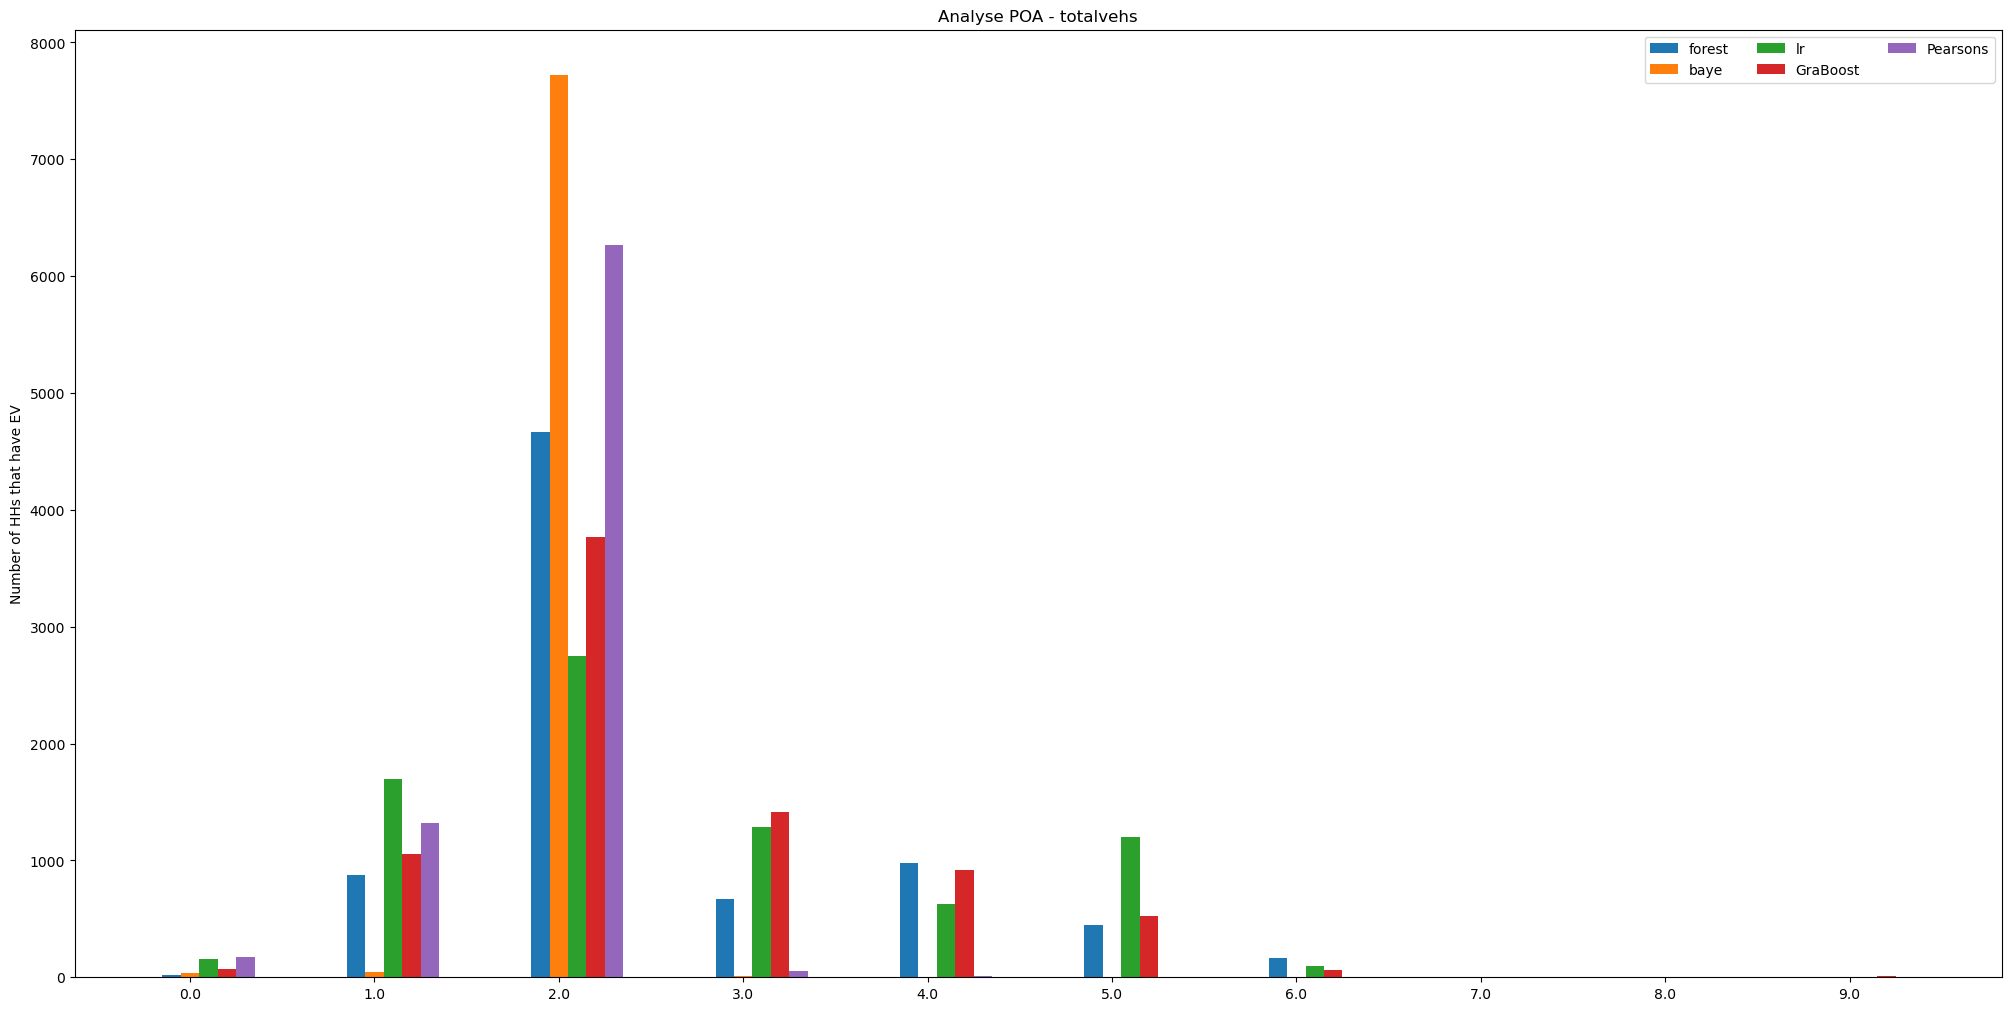

In [115]:
to_plot_mul_bars(dict_counts_methods_atts, ls_methods, "totalvehs")

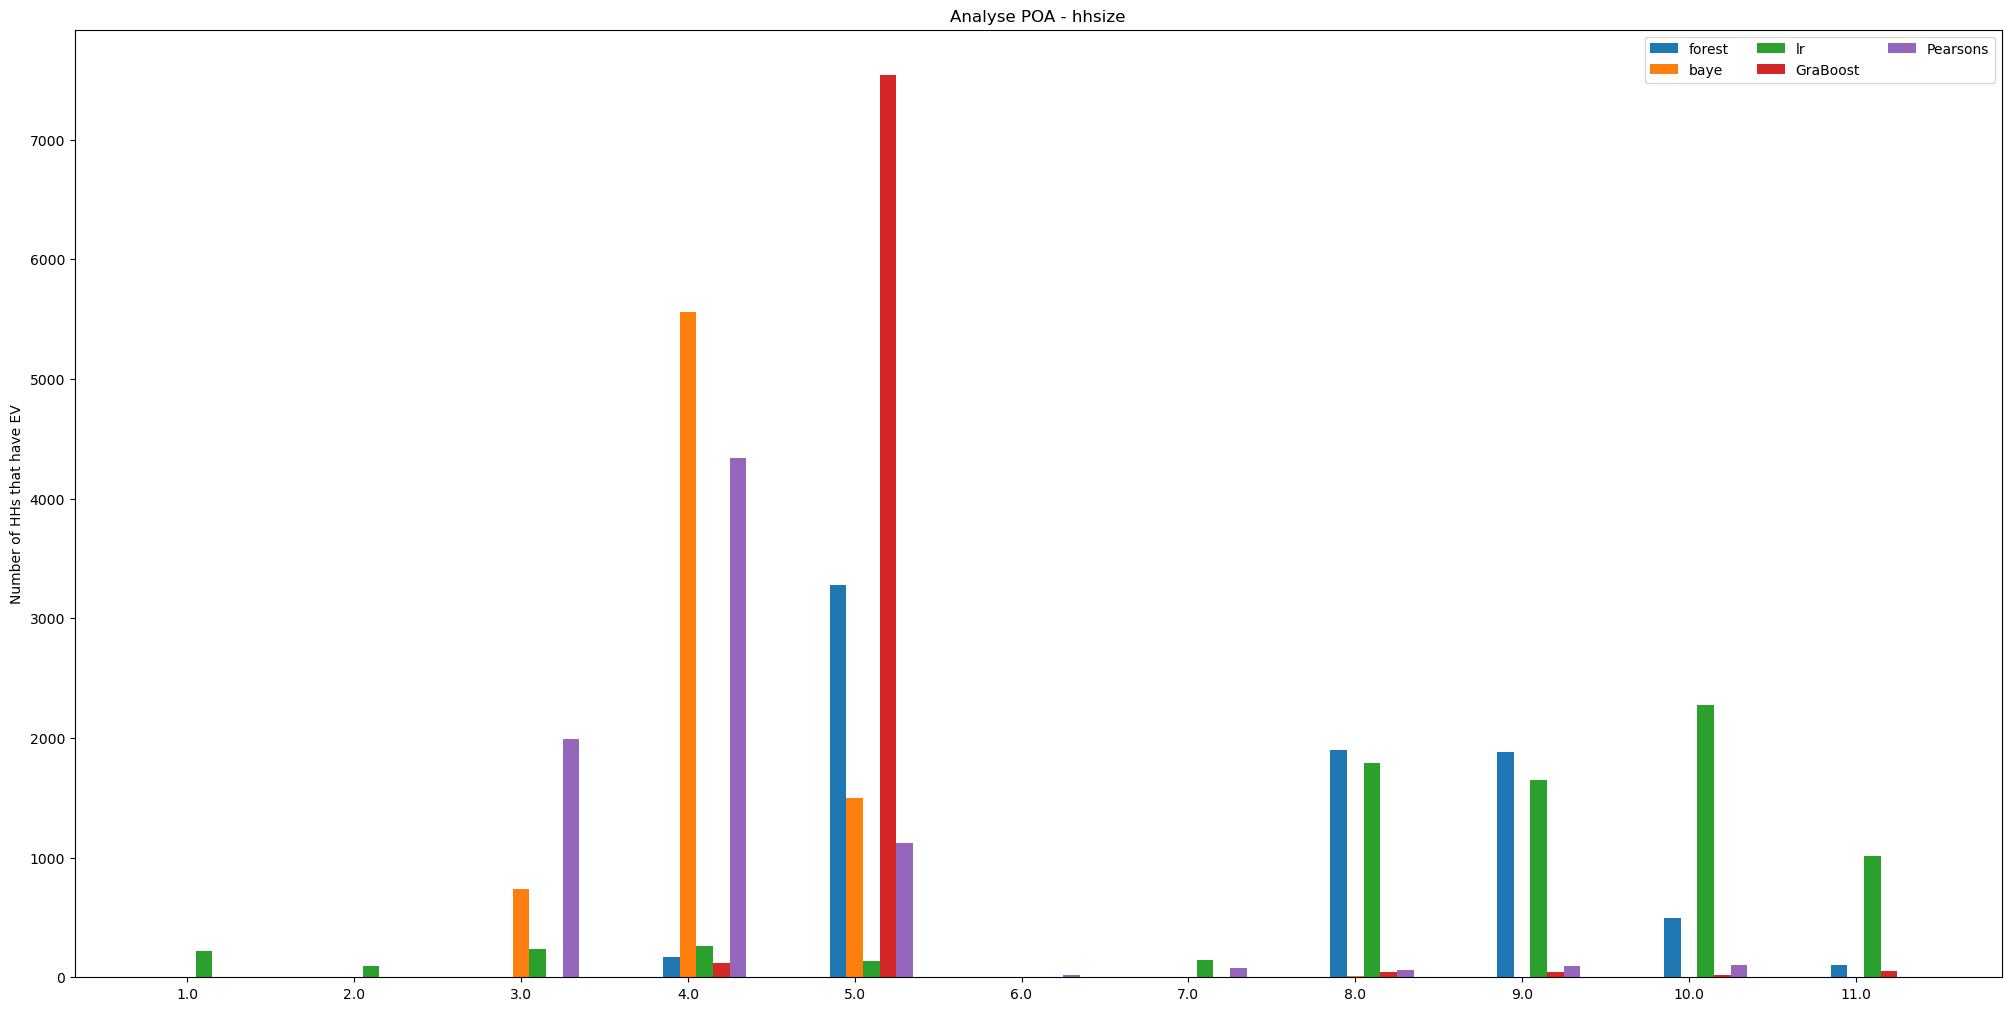

In [116]:
to_plot_mul_bars(dict_counts_methods_atts, ls_methods, "hhsize")

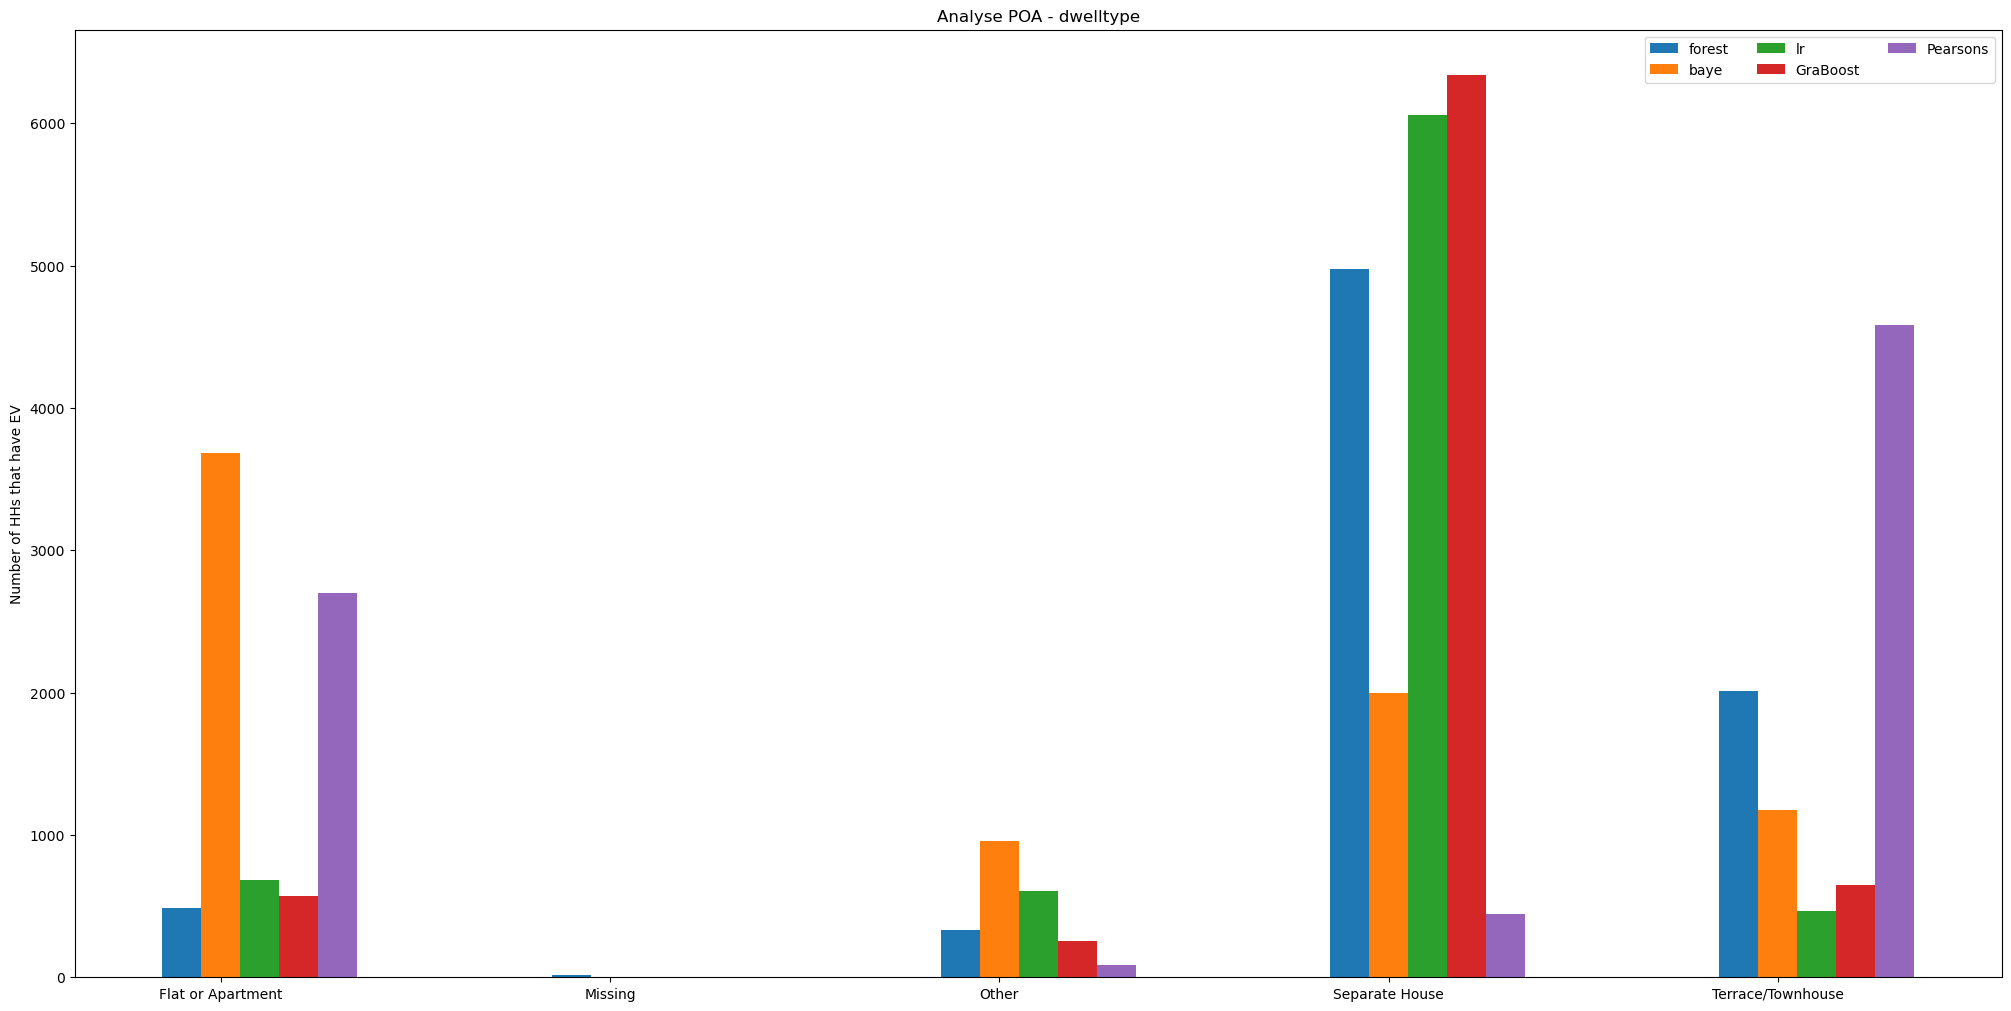

In [117]:
to_plot_mul_bars(dict_counts_methods_atts, ls_methods, "dwelltype")

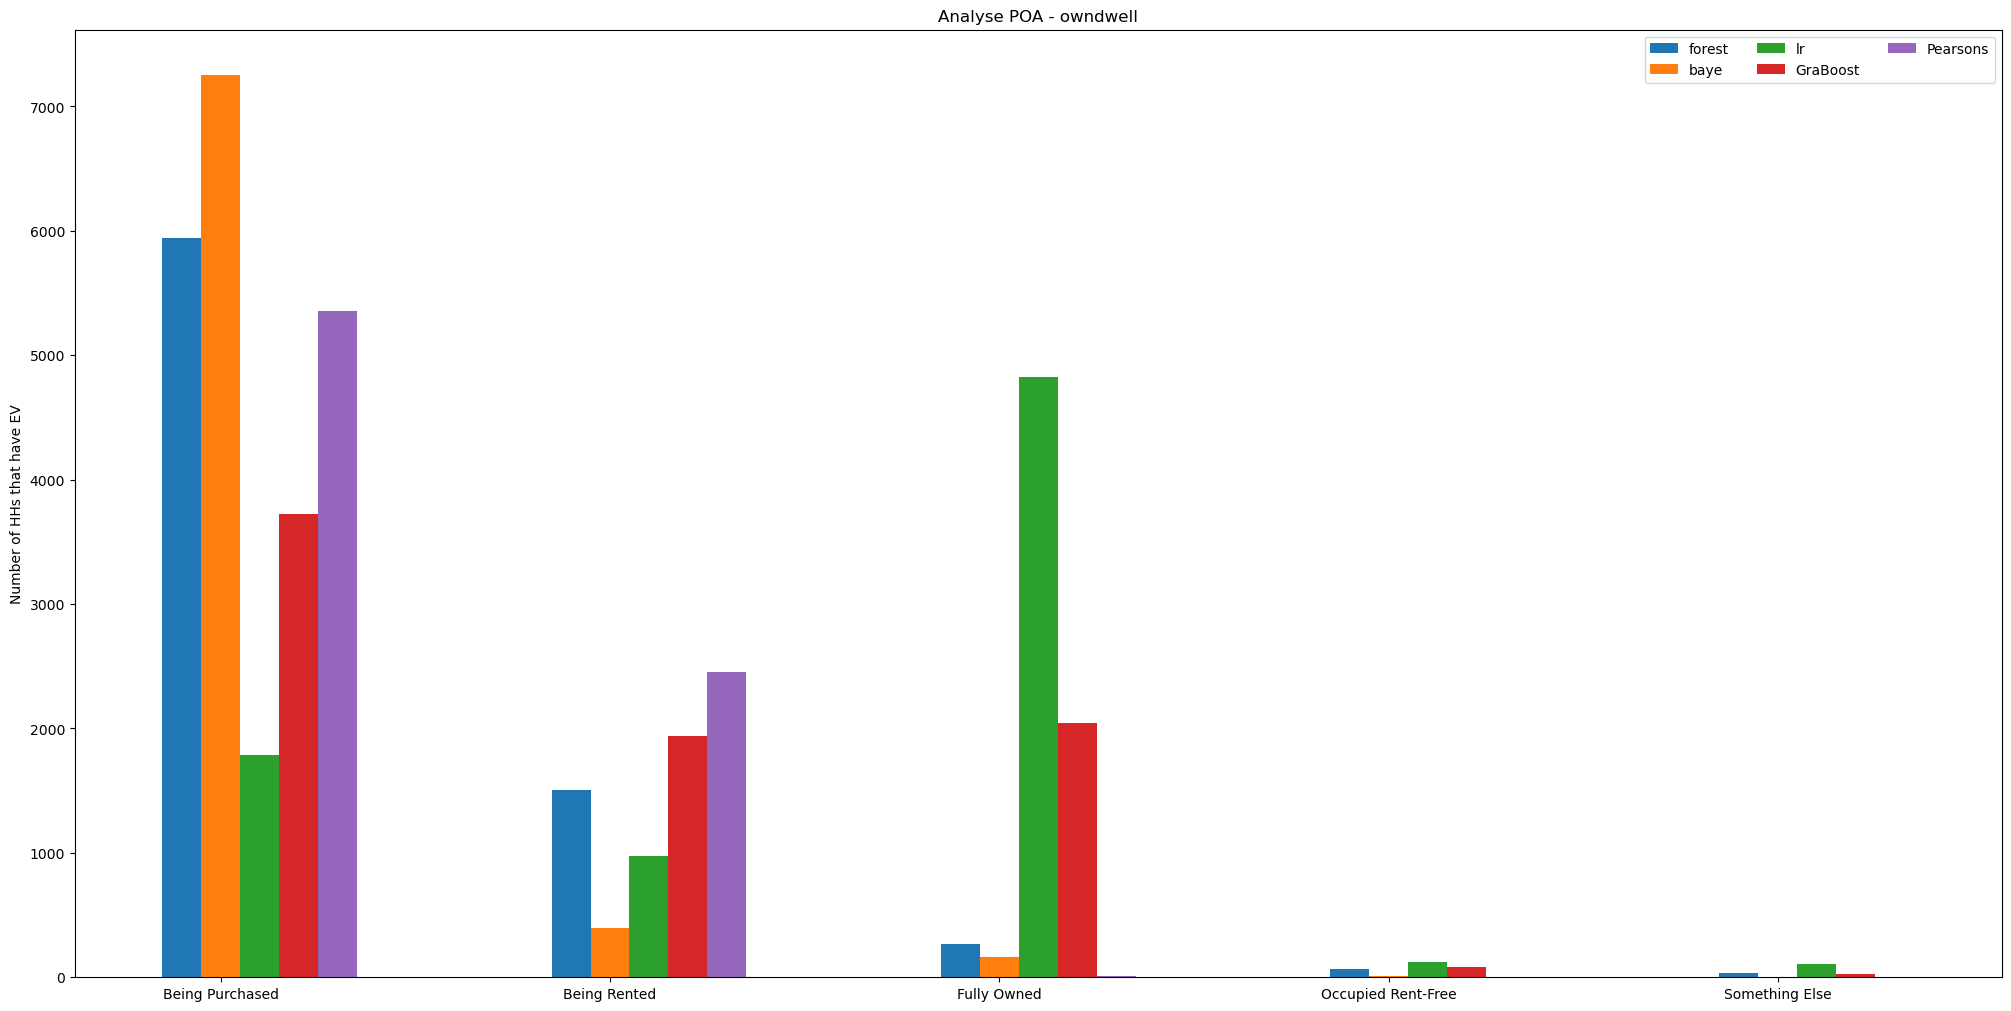

In [118]:
to_plot_mul_bars(dict_counts_methods_atts, ls_methods, "owndwell")

### Get threshold and see across area

     POA_CODE21                               POA_NAME21 AUS_CODE21  \
0          0800                                     0800        AUS   
1          0810                                     0810        AUS   
2          0812                                     0812        AUS   
3          0820                                     0820        AUS   
4          0822                                     0822        AUS   
...         ...                                      ...        ...   
2639       7469                                     7469        AUS   
2640       7470                                     7470        AUS   
2641       9494                 No usual address (Aust.)        AUS   
2642       9797  Migratory - Offshore - Shipping (Aust.)        AUS   
2643       ZZZZ                        Outside Australia        ZZZ   

             AUS_NAME21   AREASQKM21  \
0             Australia       3.1731   
1             Australia      24.4283   
2             Australia    

<Axes: >

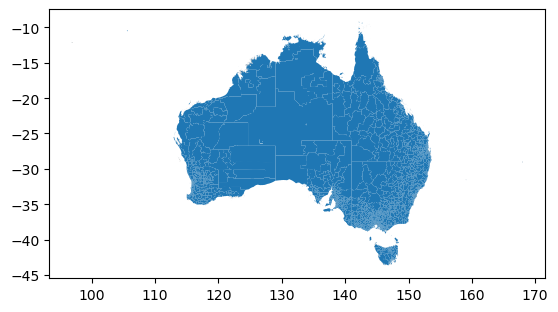

In [122]:
gdf_poa = gpd.read_file("data/POA_2021_AUST_GDA2020_SHP.zip")
print(gdf_poa)
gdf_poa.plot()

In [123]:
dict_thres

{'POA3000': {'EV_pred_forest': 0.0176744557549141,
  'EV_pred_baye': 0.0149313970684357,
  'EV_pred_lr': 0.0657462018701023,
  'EV_pred_GraBoost': 0.0116210867376025,
  'EV_pred_Pearsons': 0.4452564329349267},
 'POA3002': {'EV_pred_forest': 0.0202740118995977,
  'EV_pred_baye': 0.014780983791845,
  'EV_pred_lr': 0.0568109311406843,
  'EV_pred_GraBoost': 0.0137273919047346,
  'EV_pred_Pearsons': 0.4087658072974631},
 'POA3003': {'EV_pred_forest': 0.0224945931636275,
  'EV_pred_baye': 0.0164021878613859,
  'EV_pred_lr': 0.0739762652114486,
  'EV_pred_GraBoost': 0.0137273919047346,
  'EV_pred_Pearsons': 0.4802982333217107},
 'POA3004': {'EV_pred_forest': 0.0157190774511683,
  'EV_pred_baye': 0.0147333770840876,
  'EV_pred_lr': 0.0568109311406843,
  'EV_pred_GraBoost': 0.0113355570767535,
  'EV_pred_Pearsons': 0.3959967488286938},
 'POA3006': {'EV_pred_forest': 0.0188376144534387,
  'EV_pred_baye': 0.0163891666914628,
  'EV_pred_lr': 0.0710563143705826,
  'EV_pred_GraBoost': 0.013727391904

In [128]:
data_df_build = {
    "POA_NAME21": []
}

for zone in dict_thres:
    name = zone[3:]
    data_df_build["POA_NAME21"].append(name)
    for method in dict_thres[zone]:
        me_n = method.split("_")[-1]
        if me_n not in data_df_build:
            data_df_build[me_n] = [dict_thres[zone][method]]
        else:
            data_df_build[me_n].append(dict_thres[zone][method])

df_thres_diff = pd.DataFrame(data_df_build)
df_thres_diff

,POA_NAME21,forest,baye,lr,GraBoost,Pearsons
0,3000,0.017674,0.014931,0.065746,0.011621,0.445256
1,3002,0.020274,0.014781,0.056811,0.013727,0.408766
2,3003,0.022495,0.016402,0.073976,0.013727,0.480298
3,3004,0.015719,0.014733,0.056811,0.011336,0.395997
4,3006,0.018838,0.016389,0.071056,0.013727,0.483627
...,...,...,...,...,...,...
687,3990,0.000888,-0.008893,-0.037849,0.001441,-0.363464
688,3991,0.000830,-0.010218,-0.045338,0.001441,-0.449707
689,3992,0.000828,-0.009340,-0.061355,0.001441,-0.464207
690,3995,0.028547,0.017730,0.282661,0.014338,0.555659


<Axes: >

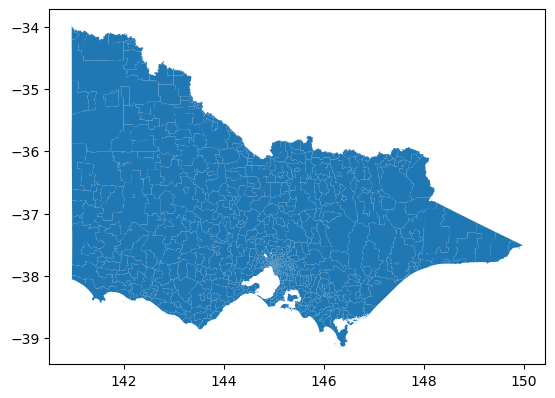

In [130]:
vic_gpd = gdf_poa.merge(df_thres_diff, on="POA_NAME21")
vic_gpd.plot()

<Axes: >

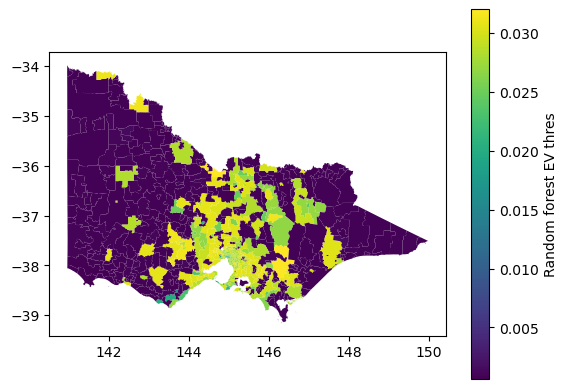

In [138]:
vic_gpd.plot(column="forest", legend=True, legend_kwds={"label": "Random forest EV thres"})

<Axes: >

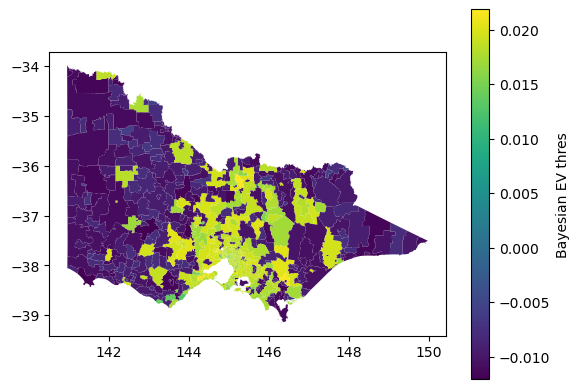

In [134]:
vic_gpd.plot(column="baye", legend=True, legend_kwds={"label": "Bayesian EV thres"})

<Axes: >

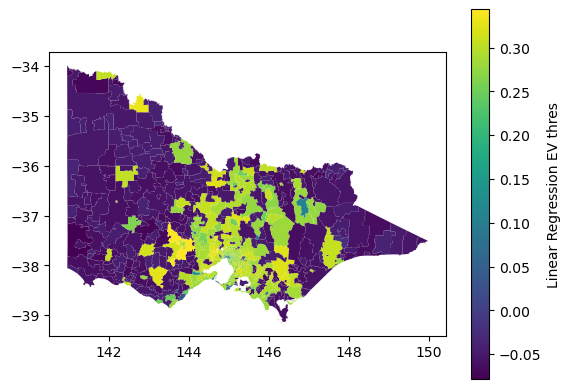

In [135]:
vic_gpd.plot(column="lr", legend=True, legend_kwds={"label": "Linear Regression EV thres"})

<Axes: >

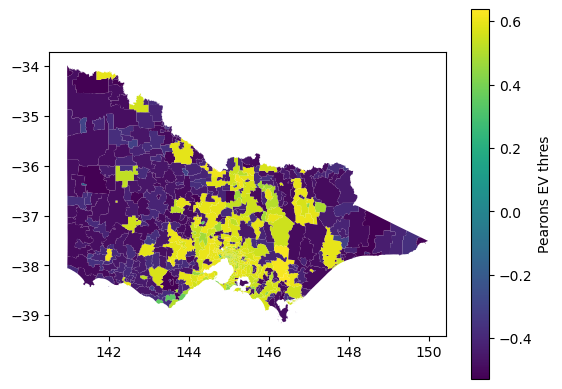

In [136]:
vic_gpd.plot(column="Pearsons", legend=True, legend_kwds={"label": "Pearons EV thres"})

<Axes: >

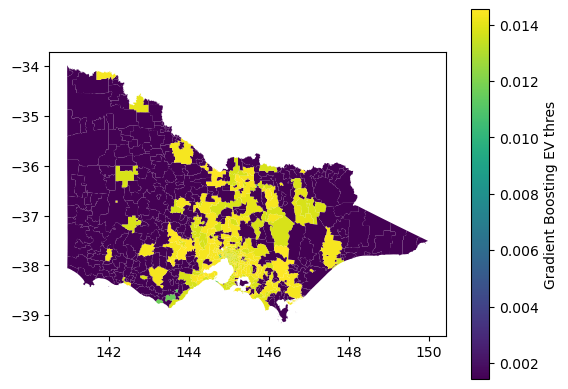

In [137]:
vic_gpd.plot(column="GraBoost", legend=True, legend_kwds={"label": "Gradient Boosting EV thres"})